In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urljoin
import re
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
import json
import os
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## 1. Data Acquisition


### 1.1 Scrape electricity sector emissions and generation data from websites

In [2]:
BASE = "https://api.cer.gov.au/datahub-public/v1/"
SCHEME_ID = "NGER"
YEAR_MIN, YEAR_MAX = 2014, 2024
SAVE_DIR = "./nger_csv"
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/124.0.0.0 Safari/537.36"
})

In [3]:
catalog_url = urljoin(BASE, f"api/Schemes/{SCHEME_ID}/DatasetCatalogItems")
def get_json(url, params=None, timeout=15):
    r = session.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return r.json()
catalog = get_json(catalog_url)
catelog_items = catalog.get("items", catalog) if isinstance(catalog, dict) else catalog

In [4]:
def download_file(url,filepath,timeout=30):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with open(filepath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1<<14):
                if chunk: f.write(chunk)

In [20]:
pattern = re.compile(
r"Greenhouse and energy information by designated generation facility\s*(20\d{2})[–-](\d{2})",    re.IGNORECASE
)
dataset_url =urljoin(BASE,f'api/Dataset/{SCHEME_ID}/dataset/')
for item in catelog_items:
    title = item.get("displayName")
    m = pattern.search(title)
    if m:
        start_year = int(m.group(1))
        end_suffix = int(m.group(2))
        end_year = int(str(start_year)[:2] + f"{end_suffix:02d}")
        if start_year < YEAR_MIN or end_year > YEAR_MAX:
            continue
        dataset_id = item.get("id")
        download_url = urljoin(dataset_url, f'{dataset_id}.csv')
        print(f"{download_url}")
        save_path = os.path.join(SAVE_DIR, f"{start_year}-{end_year}.csv")
        print(f"{title}  -> {start_year}-{end_year}, datasetId={dataset_id}")
        try:
            print(f'Downloading -> {save_path}')
            download_file(download_url, save_path)
            time.sleep(1)
        except requests.HTTPError as e:
            print(f"HTTP Error {e.response.status_code}")
print("All files downloaded")

https://api.cer.gov.au/datahub-public/v1/api/Dataset/NGER/dataset/ID0083.csv
Greenhouse and energy information by designated generation facility 2022-23  -> 2022-2023, datasetId=ID0083
https://api.cer.gov.au/datahub-public/v1/api/Dataset/NGER/dataset/ID0079.csv
Greenhouse and energy information by designated generation facility 2018-19  -> 2018-2019, datasetId=ID0079
https://api.cer.gov.au/datahub-public/v1/api/Dataset/NGER/dataset/ID0082.csv
Greenhouse and energy information by designated generation facility 2021-22  -> 2021-2022, datasetId=ID0082
https://api.cer.gov.au/datahub-public/v1/api/Dataset/NGER/dataset/ID0243.csv
Greenhouse and energy information by designated generation facility 2023–24  -> 2023-2024, datasetId=ID0243
https://api.cer.gov.au/datahub-public/v1/api/Dataset/NGER/dataset/ID0080.csv
Greenhouse and energy information by designated generation facility 2019-20  -> 2019-2020, datasetId=ID0080
https://api.cer.gov.au/datahub-public/v1/api/Dataset/NGER/dataset/ID0076.cs

### 1.2 Scrape proposed and planned large-scale renewable power stations data from websites

In [39]:
PAGE_URL = 'https://cer.gov.au/markets/reports-and-data/large-scale-renewable-energy-data'
abs_out_path = "./abs_csv"
response = requests.get(PAGE_URL,timeout=15)
response.raise_for_status()
soup = BeautifulSoup(response.text, "html.parser")
#all the files download url are the brother node under the h4 title, but after first try the h4 only has text <h4> Raw data in CSV format</h4> it has no id in the response, but at the website it  has an id called raw-data-in-csv-format so it has to be changed to find all h4 then do the regex
for h4 in soup.find_all("h4"):
    if "raw data in csv format" in h4.get_text(strip=True).lower():
        #the link is in the first brother node under the h4 which is <a> and the link is in the parameter href
        a =h4.find_next("a",attrs={"download":True})
        #it is half of the download url it needs to concat with the base url, the full link can be tested and which is just the page url + href
        href = a["href"]
        csv_url = urljoin(PAGE_URL,href)
        if "power-stations-and-projects" in href or "power stations and projects" in href.lower():
            print(f"Downloading {csv_url}")
            file_name = os.path.basename(href)+".csv" 
            download_file(csv_url,os.path.join(abs_out_path,file_name))
            time.sleep(1)
            print(f"Downloaded {file_name}")
        print("--------------------------------------------------------")
print("All files downloaded")

--------------------------------------------------------
Downloaded power-stations-and-projects-accredited.csv
--------------------------------------------------------
Downloaded power-stations-and-projects-committed.csv
--------------------------------------------------------
Downloaded power-stations-and-projects-probable.csv
--------------------------------------------------------
--------------------------------------------------------
All files downloaded


### 1.3 Scrape Economy and Industry data from website

In [43]:
ABS_REGION_URL = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24#data-downloads"
abs_region_path = "./abs_region_xslx"
def download_file_from_abs_by_region(ABS_REGION_URL,region,filepath,timeout=30):
    response = requests.get(ABS_REGION_URL,timeout=15)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    h4 = soup.find("h4",string=lambda t: t and region in t)
    if not h4:
        raise SystemExit("Not find such h4")
    parent = h4.find_parent("l1",class_="field__item")
    a = parent.find_next("a",href=True) if parent else h4.find_next("a",href=True)
    if not a:
        raise SystemExit("Not find such download link")
    href = a["href"]
    file_url = urljoin(ABS_REGION_URL,href)
    print(f"Downloading {file_url}")
    label = a['aria-label']
    file_name =label+".xlsx"
    download_file(file_url,os.path.join(filepath,file_name))
    print(f"Downloaded {file_name}")

In [44]:
economy_region='Economy and industry, ASGS and LGA, 2011, 2016-2024'
download_file_from_abs_by_region(ABS_REGION_URL,economy_region,abs_region_path)
# population_region ="Population and people, ASGS, LGA, and RA, 2011, 2016-2024"
# download_file_from_abs_by_region(ABS_REGION_URL,population_region,abs_region_path)

Downloaded Download - Economy and industry, ASGS and LGA, 2011, 2016-2024 xlsx 18.75 MB.xlsx
Downloaded Download - Population and people, ASGS, LGA, and RA, 2011, 2016-2024 xlsx 26.03 MB.xlsx


## 2. Data Integration and Cleaning

### 2.1 Useful Tools

In [92]:
def normalize_col(col:str)->str:
    if not col or not isinstance(col,str):
        return 'UNKNOWN'
    text  = col.strip().lower()
    if re.search(r"(total\s+)?scope\s*1", text):
        return "Total_Scope_1_t_CO2_Emissions"
    if re.search(r"(total\s+)?scope\s*2", text):
        return "Total_Scope_2_t_CO2_Emissions"
    if re.search(r"electricity\s+production.*gj",text):
        return "Electricity_Production_GJ"
    if re.search(r"electricity\s+production.*mwh",text):
        return "Electricity_Production_MWh"
    if re.search(r"primary\s+fuel",text):
        return "Primary_Fuel"
    if re.search(r"total\s+emissions",text):
        return "Total_Emissions_t_CO2_e"
    if re.search(r"emission\s+intensity",text):
        return "Emissions_Intensity_t_CO2_e_MWh"
    if re.search(r"important\s+notes",text):
        return "Important_Notes"
    if re.search(r"facility\s+name",text):
        return "Facility_Name"
    if re.search(r"grid\s+connected",text):
        return "Grid_Connected"
    if re.search(r"reporting\s+entity",text) or re.search(r"controlling\scorporation",text):
        return "Reporting_Entity"
    return text
def extract_power_station_name(text):
    text = text.split("-")[0].strip() 
    return text

### 2.2 Deal with the electricity sector emissions and generation data

#### 2.2.1 Combine datasets to one dataset

There are different column names in different years, which need to map them into one

In [85]:
nger_csv_dir = "./nger_csv"
all_df =[]
for fname in os.listdir(nger_csv_dir):
    if fname.endswith(".csv"):
        path = os.path.join(nger_csv_dir,fname)
        df = pd.read_csv(path)
        df.columns = [normalize_col(c) for c in df.columns] 
        year_str = fname.replace(".csv","")
        start_year = year_str.split("-")[0]
        df['year'] = start_year
        all_df.append(df)
final_df = pd.concat(all_df, ignore_index=True)
final_df.to_csv("./nger_csv/2014-2024.csv",index=False)
nger = pd.read_csv("./nger_csv/2014-2024.csv")
nger

#### 2.2.2 Data processing

In [75]:
nger = nger.replace(r'-', pd.NA, regex=True)
nger = nger.dropna(subset=['Facility_Name'])
nger

,Reporting_Entity,Facility_Name,type,state,Electricity_Production_GJ,Electricity_Production_MWh,Total_Scope_1_t_CO2_Emissions,Total_Scope_2_t_CO2_Emissions,Total_Emissions_t_CO2_e,Emissions_Intensity_t_CO2_e_MWh,Grid_Connected,grid,Primary_Fuel,Important_Notes,year
0,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312,0.0,On,NEM,Wind,NaN,2014
1,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15,0.0,On,NEM,Solar,NaN,2014
2,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221,0.0,On,NEM,Wind,NaN,2014
3,ACCIONA ENERGY OCEANIA PTY LTD,Corporate Total,C,NaN,3242637.0,900733.0,96.0,1452.0,1548,NaN,NaN,NaN,NaN,NaN,2014
4,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094.0,38082.0,5.0,17.0,22,0.0,On,NEM,Hydro,NaN,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5937,WIRTGEN ENERGY GLENROWAN PTY. LTD,Corporate Total,C,<NA>,766484.0,212912.0,60.0,543.0,603,NaN,<NA>,<NA>,<NA>,<NA>,2023
5938,WOOLOOGA HOLDCO 2 PTY LTD,Woolooga SF,F,QLD,1185741.0,329373.0,59.0,3658.0,3717,0.0,On,NEM,Solar,<NA>,2023
5939,WOOLOOGA HOLDCO 2 PTY LTD,Corporate Total,C,<NA>,1185741.0,329373.0,59.0,3658.0,3717,NaN,<NA>,<NA>,<NA>,<NA>,2023
5940,YATPOOL SOLAR FARM HOLDCO PTY LTD,YATPOOL SOLAR FARM,F,VIC,461024.0,128062.0,0.0,361.0,361,0.0,On,NEM,Solar,<NA>,2023


### 2.2 Deal with Renewable Power stations

In [90]:
accredited_power_station = pd.read_csv("./abs_csv/power-stations-and-projects-accredited.csv")
committed_power_stations = pd.read_csv("./abs_csv/power-stations-and-projects-committed.csv")
probable_power_stations = pd.read_csv("./abs_csv/power-stations-and-projects-probable.csv")

#### 2.2.1 Clean the power-stations-and-projects-accredited

In [93]:
accredited_power_station['Power station name']=accredited_power_station['Power station name'].apply(extract_power_station_name)
accredited_power_station['Accreditation start date'] = pd.to_datetime(
    accredited_power_station['Accreditation start date'],
    format="%d/%m/%Y",
    errors='coerce').dt.date
accredited_power_station['Approval date'] = pd.to_datetime(
    accredited_power_station['Approval date'],
    format="%d/%m/%Y",
    errors='coerce'
).dt.date
accredited_power_station

,Accreditation code,Power station name,State,Postcode,Installed capacity (MW),Fuel Source (s),Accreditation start date,Approval date
0,SRPXQLE8,"Laura Johnson Home, Townview",QLD,4825,0.2265,Solar,2024-10-15,2025-01-13
1,SRPYNS39,Leppington,NSW,2179,0.7320,Solar,2024-11-22,2025-01-13
2,SRPYNS58,Quakers Hillside Care Community,NSW,2763,0.1996,Solar,2024-12-19,2025-01-13
3,SRPXVCN4,Rest Nominees,VIC,3008,0.1188,Solar,2024-09-20,2025-01-13
4,SRPXQLF9,Retail First Mt Ommaney,QLD,4074,1.0004,Solar,2024-10-29,2025-01-13
...,...,...,...,...,...,...,...,...
275,SRPXVCT8,Liuzzi 71 Gower St,VIC,3072,0.4000,Solar,2025-07-21,2025-08-27
276,SRPXQLM5,Mercy Community,QLD,4014,0.8530,Solar,2025-08-04,2025-08-27
277,SRPXVCP9,Norther Airfield,VIC,3045,11.2780,Solar,2025-06-01,2025-08-27
278,SRPVWAN8,Rose Farms,WA,6220,0.2000,Solar,2025-08-04,2025-08-27


#### 2.2.2 Clean the power-stations-and-projects-committed

In [ ]:
committed_power_stations['Committed Date (Month/Year)']  = pd.to_datetime(
    committed_power_stations["Committed Date (Month/Year)"],
    format="%b-%Y",
    errors="coerce" 
).dt.to_period("M")
committed_power_stations.columns = [c.strip() for c in committed_power_stations.columns]
committed_power_stations["Committed Date (Month/Year)"] =committed_power_stations["Committed Date (Month/Year)"].astype(str)

#### 2.2.3 Clean the power-stations-and-projects-probable

In [ ]:
probable_power_stations.columns = [c.strip() for c in probable_power_stations.columns]

## 3 Data Augmenttation

### 3.1 Useful Tools

In [ ]:
with open("config.json") as f:
    cfg = json.load(f)
API_KEY =cfg['API_KEY']
address=""
GEOCODE_URL=cfg['GEOCODE_URL']
params = {"address": address, 
          "key": API_KEY,
          "components": "country:AU",
          "region": "au",
          "language": "en-AU",}
STATE_MAP = {
    "NSW": "New South Wales",
    "VIC": "Victoria",
    "QLD": "Queensland",
    "SA":  "South Australia",
    "WA":  "Western Australia",
    "TAS": "Tasmania",
    "ACT": "Australian Capital Territory",
    "NT":  "Northern Territory",
}
def norm_state(s):
    if not isinstance(s, str): return ""
    s = s.strip()
    return STATE_MAP.get(s.upper(), s)
def _parse_components_google(components):
    out = {
        "country": None,
        "state_std": None,
        "city": None,
        "lga": None,
        "postcode": None,
        "suburb": None,
    }
    locality = None
    sublocality = None
    neighborhood = None
    for c in components:
        types = c.get("types", [])
        name = c.get("long_name")

        if "country" in types:
            out["country"] = name
        if "administrative_area_level_1" in types:
            out["state_std"] = name
        if "administrative_area_level_2" in types:
            out["city"] = name
        if "postal_code" in types:
            out["postcode"] = name
        if "locality" in types:
            locality = name                     
        if "sublocality_level_1" in types or "sublocality" in types:
            sublocality = name
        if "neighborhood" in types or "political" in types and "neighborhood" in types:
            neighborhood = name

    out["suburb"] = sublocality or neighborhood or locality
    out["lga"] = locality

    return out

def enrich_facilities_google(
    df: pd.DataFrame,
    api_key: str,
    address: str = "Facility_Name",
    state_col: str = "state",
    sleep_sec: float = 0.12,
    language: str = "en-AU",
    geo_url: str = GEOCODE_URL,
) -> pd.DataFrame:

    GEOCODE_URL = geo_url

    def _geocode_fac_state(facility: str, state_val: str):
        state_full = norm_state(state_val)
        query = f"{facility}, {state_full}, Australia" if state_full else f"{facility}, Australia"
        params = {
            "address": query, "key": api_key, "components": "country:AU",
            "region": "au", "language": language,
        }
        resp = requests.get(GEOCODE_URL, params=params, timeout=10).json()
        if resp.get("status") != "OK" or not resp.get("results"):
            return None
        res = resp["results"][0]
        comp = _parse_components_google(res.get("address_components", []))
        if comp.get("country") != "Australia":
            return None
        loc = res["geometry"]["location"]
        return {
            address: facility,
            state_col: state_val,
            "lat": loc["lat"],
            "lng": loc["lng"],
            "lga": comp.get("lga"),
            "city": comp.get("city"),
            "state_std": comp.get("state_std"),
            "postcode": comp.get("postcode"),
            "country": comp.get("country"),
            "formatted_address": res.get("formatted_address"),
            "query_used": query,
        }

    target_cols = ["lat","lng","lga","city","state_std","postcode","country","formatted_address","query_used"]
    for c in target_cols:
        if c not in df.columns:
            df[c] = pd.NA

    # (facility, state) unique to search
    pairs = (
        df[[address, state_col]]
        .dropna(subset=[address])
        .drop_duplicates()
        .itertuples(index=False, name=None)
    )

    cache, rows = {}, []
    for fac, st in pairs:
        key = (fac, st)
        info = cache.get(key)
        if info is None:
            info = _geocode_fac_state(fac, st)
            cache[key] = info
            time.sleep(sleep_sec)
        if info:
            rows.append(info)

    geo_df = pd.DataFrame(rows)

    out = df.merge(geo_df, on=[address, state_col], how="left", suffixes=("", "_new"))
    for c in target_cols:
        if c + "_new" in out.columns:
            out[c] = out[c].fillna(out[c + "_new"])
            out = out.drop(columns=[c + "_new"])
    return out

### 3.2 Augument the accredited, committed, and probable data

In [ ]:
accredited_power_station = enrich_facilities_google(accredited_power_station, api_key=API_KEY,address="Power station name", state_col="State", sleep_sec=0.12)
accredited_power_station.to_csv("./abs_csv/accredited_power_station_with_lat_lng.csv",index=False)
committed_power_stations = enrich_facilities_google(committed_power_stations, api_key=API_KEY,address="Project Name", state_col="State", sleep_sec=0.12)
committed_power_stations.to_csv("./abs_csv/committed_power_stations_with_lat_lng.csv",index=False)

probable_power_stations = enrich_facilities_google(probable_power_stations, api_key=API_KEY,address="Project Name", state_col="State", sleep_sec=0.12)
probable_power_stations.to_csv("./abs_csv/probable_power_stations_with_lat_lng.csv",index=False)

## 4. Data Transformation and Storage

### 4.1 Database Connection

In [ ]:
with open("config.json") as f:
    cfg = json.load(f)

db_url = (
    f"postgresql+psycopg2://{cfg['DB_USER']}:{cfg['DB_PASS']}"
    f"@{cfg['DB_HOST']}:{cfg['DB_PORT']}/{cfg['DB_NAME']}"
)

try:
    engine = create_engine(db_url, future=True)
    with engine.connect() as conn:
        conn.execute(text('''CREATE EXTENSION postgis;
                            CREATE EXTENSION postgis_topology;'''))
    print("Successfully connected to database")
    
except SQLAlchemyError as e:
    print("Connection Failed", e)

### 4.2 Store electricity sector emissions and generation data into database

In [ ]:
create_table_sql = '''
CREATE TABLE IF NOT EXISTS nger(
    id SERIAL PRIMARY KEY,
    year INT,
    reporting_entity TEXT,
    facility_name TEXT,
    type TEXT,
    state TEXT,
    electricity_production_gj REAL,
    electricity_production_mwh REAL,
    total_scope_1_t_co2_emissions REAL,
    total_scope_2_t_co2_emissions REAL,
    total_emissions_t_co2_e REAL,
    emissions_intensity_t_co2_e_mwh REAL,
    grid_connected TEXT,
    grid TEXT,
    primary_fuel TEXT,
    important_notes TEXT
);
'''
with engine.begin() as conn:
    try:
        conn.execute(text(create_table_sql))
        print("Successfully created table")
    except SQLAlchemyError as e:
        print("Create table failed", e)
batch_size = 500
with engine.begin() as conn:
    for start in range(0, len(nger), batch_size):
        chunk = nger.iloc[start:start+batch_size]
        rows = chunk.to_dict(orient="records")
        conn.execute(
            text("""
                INSERT INTO nger (
                    reporting_entity, facility_name, type, state,
                    electricity_production_gj, electricity_production_mwh,
                    total_scope_1_t_co2_emissions, total_scope_2_t_co2_emissions,
                    total_emissions_t_co2_e, emissions_intensity_t_co2_e_mwh,
                    grid_connected, grid, primary_fuel, important_notes, year
                ) VALUES (
                    :Reporting_Entity, :Facility_Name, :type, :state,
                    :Electricity_Production_GJ, :Electricity_Production_MWh,
                    :Total_Scope_1_t_CO2_Emissions, :Total_Scope_2_t_CO2_Emissions,
                    :Total_Emissions_t_CO2_e, :Emissions_Intensity_t_CO2_e_MWh,
                    :Grid_Connected, :grid, :Primary_Fuel, :Important_Notes, :year
                )
            """),
            rows
        )

### 4.3 Store power stations and projects data into database

In [44]:
create_table_sql = '''
CREATE TABLE IF NOT EXISTS accredited_power_station (
    accreditation_code TEXT PRIMARY KEY ,
    power_station_name TEXT,
    state VARCHAR(10),
    postcode VARCHAR(10),
    installed_capacity_mw DOUBLE PRECISION,
    fuel_source TEXT,
    accreditation_start_date DATE,
    approval_date DATE,
    lga TEXT,
    city TEXT,
    state_std TEXT,
    postcode_std VARCHAR(10),
    country TEXT,
    formatted_address TEXT,
    query_used TEXT,
    geom geometry(Point, 4326)
);

'''

with engine.begin() as conn:
    try:
        conn.execute(text(create_table_sql))
        print("Successfully created table")
    except SQLAlchemyError as e:
        print("Create table failed", e)

insert_sql = text("""
    INSERT INTO accredited_power_station (
        accreditation_code, power_station_name, state, postcode,
        installed_capacity_mw, fuel_source,
        accreditation_start_date, approval_date,
        lga, city, state_std, postcode_std,
        country, formatted_address, query_used,
        geom
    ) VALUES (
        :accreditation_code, :power_station_name, :state, :postcode,
        :installed_capacity_mw, :fuel_source,
        :accreditation_start_date, :approval_date,
        :lga, :city, :state_std, :postcode_std,
        :country, :formatted_address, :query_used,
        ST_SetSRID(ST_MakePoint(:lng, :lat), 4326)
    )
""")
with engine.begin() as conn:
    for _, row in accredited_power_station.iterrows():
        conn.execute(insert_sql, {
            "accreditation_code": row["Accreditation code"],
            "power_station_name": row["Power station name"],
            "state": row["State"],
            "postcode": str(row["Postcode"]) if pd.notna(row["Postcode"]) else None,
            "installed_capacity_mw": row["Installed capacity (MW)"],
            "fuel_source": row["Fuel Source (s)"],
            "accreditation_start_date": row["Accreditation start date"],
            "approval_date": row["Approval date"],
            "lga": row["lga"],
            "city": row["city"],
            "state_std": row["state_std"],
            "postcode_std": str(row["postcode"]) if pd.notna(row["postcode"]) else None,
            "country": row["country"],
            "formatted_address": row["formatted_address"],
            "query_used": row["query_used"],
            "lat": row["lat"],
            "lng": row["lng"]
        })
create_table_sql = '''
DROP TABLE IF EXISTS committed_power_stations;
CREATE TABLE IF NOT EXISTS committed_power_stations (
    id SERIAL PRIMARY KEY,
    project_name TEXT,
    state TEXT,
    mw_capacity REAL,
    fuel_source TEXT,
    committed_date TEXT,  -- 从 "Month/Year" 转换过来存第一天
    lga TEXT,
    city TEXT,
    state_std TEXT,
    postcode TEXT,
    country TEXT,
    formatted_address TEXT,
    query_used TEXT,
    geom GEOMETRY(Point, 4326) -- 经纬度点
);
'''

insert_sql = '''
INSERT INTO committed_power_stations (
    project_name, state, mw_capacity, fuel_source,
    committed_date, lga, city, state_std, postcode,
    country, formatted_address, query_used, geom
) VALUES (
    :project_name, :state, :mw_capacity, :fuel_source,
    :committed_date, :lga, :city, :state_std, :postcode,
    :country, :formatted_address, :query_used,
    ST_SetSRID(ST_MakePoint(:lng, :lat), 4326)
);
'''
with engine.begin() as conn:
    try:
        conn.execute(text(create_table_sql))
        print("Successfully created table")
    except SQLAlchemyError as e:
        print("Create table failed", e)
with engine.begin() as conn:
    for _, row in committed_power_stations.iterrows():
        conn.execute(text(insert_sql), {
            "project_name": row["Project Name"],
            "state": row["State"],
            "mw_capacity": row["MW Capacity"],
            "fuel_source": row["Fuel Source"],
            "committed_date": row["Committed Date (Month/Year)"],
            "lga": row["lga"],
            "city": row["city"],
            "state_std": row["state_std"],
            "postcode": str(row["postcode"]) if pd.notna(row["postcode"]) else None,
            "country": row["country"],
            "formatted_address": row["formatted_address"],
            "query_used": row["query_used"],
            "lat": row["lat"],
            "lng": row["lng"]
        })
        
create_table_sql='''
DROP TABLE IF EXISTS probable_power_stations;
CREATE TABLE IF NOT EXISTS probable_power_stations (
    id SERIAL PRIMARY KEY,
    project_name TEXT,
    state TEXT,
    mw_capacity REAL,
    fuel_source TEXT,
    lga TEXT,
    city TEXT,
    state_std TEXT,
    postcode TEXT,
    country TEXT,
    formatted_address TEXT,
    query_used TEXT,
    geom GEOMETRY(Point, 4326)  -- 经纬度点
);
'''
with engine.begin() as conn:
    try:
        conn.execute(text(create_table_sql))
        print("Successfully created table")
    except SQLAlchemyError as e:
        print("Create table failed", e)
insert_sql='''
INSERT INTO probable_power_stations (
    project_name, state, mw_capacity, fuel_source,
    lga, city, state_std, postcode, country,
    formatted_address, query_used, geom
) VALUES (
    :project_name, :state, :mw_capacity, :fuel_source,
    :lga, :city, :state_std, :postcode, :country,
    :formatted_address, :query_used,
    ST_SetSRID(ST_MakePoint(:lng, :lat), 4326)
);
'''
with engine.begin() as conn:
    for _, row in probable_power_stations.iterrows():
        conn.execute(text(insert_sql), {
            "project_name": row["Project Name"],
            "state": row["State"],
            "mw_capacity": row["MW Capacity"],
            "fuel_source": row["Fuel Source"],
            "lga": row["lga"],
            "city": row["city"],
            "state_std": row["state_std"],
            "postcode": str(row["postcode"]) if pd.notna(row["postcode"]) else None,
            "country": row["country"],
            "formatted_address": row["formatted_address"],
            "query_used": row["query_used"],
            "lat": row["lat"],
            "lng": row["lng"]
        })

C:\Users\jiang\AppData\Local\Temp\ipykernel_21268\291537573.py:132: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[c] = out[c].fillna(out[c + "_new"])
C:\Users\jiang\AppData\Local\Temp\ipykernel_21268\291537573.py:132: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[c] = out[c].fillna(out[c + "_new"])


,Accreditation code,Power station name,State,Postcode,Installed capacity (MW),Fuel Source (s),Accreditation start date,Approval date,lat,lng,lga,city,state_std,postcode,country,formatted_address,query_used
0,SRPXQLE8,"Laura Johnson Home, Townview",QLD,4825,0.2265,Solar,15/10/2024,13/01/2025,-20.734233,139.503486,Townview,Mount Isa City,Queensland,4825,Australia,"41 Clarke St, Townview QLD 4825, Australia","Laura Johnson Home, Townview, Queensland, Aust..."
1,SRPYNS39,Leppington,NSW,2179,0.7320,Solar,22/11/2024,13/01/2025,-33.977302,150.783435,Leppington,None,New South Wales,2179,Australia,"Leppington NSW 2179, Australia","Leppington, New South Wales, Australia"
2,SRPYNS58,Quakers Hillside Care Community,NSW,2763,0.1996,Solar,19/12/2024,13/01/2025,-33.719511,150.891607,Quakers Hill,City of Blacktown,New South Wales,2763,Australia,"35 Hambledon Rd, Quakers Hill NSW 2763, Australia","Quakers Hillside Care Community, New South Wal..."
3,SRPXVCN4,Rest Nominees,VIC,3008,0.1188,Solar,20/09/2024,13/01/2025,-36.984781,143.390607,None,None,Victoria,None,Australia,"Victoria, Australia","Rest Nominees, Victoria, Australia"
4,SRPXQLF9,Retail First Mt Ommaney,QLD,4074,1.0004,Solar,29/10/2024,13/01/2025,-27.485212,152.992406,Toowong,Brisbane City,Queensland,4066,Australia,"Toowong QLD 4066, Australia","Retail First Mt Ommaney, Queensland, Australia"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,SRPXVCT8,Liuzzi 71 Gower St,VIC,3072,0.4000,Solar,21/07/2025,27/08/2025,-37.743696,145.024684,Preston,Darebin City,Victoria,3072,Australia,"71 Gower St, Preston VIC 3072, Australia","Liuzzi 71 Gower St, Victoria, Australia"
276,SRPXQLM5,Mercy Community,QLD,4014,0.8530,Solar,4/08/2025,27/08/2025,-27.364344,153.094650,Nudgee,Brisbane City,Queensland,4014,Australia,"131 Queens Rd, Nudgee QLD 4014, Australia","Mercy Community, Queensland, Australia"
277,SRPXVCP9,Norther Airfield,VIC,3045,11.2780,Solar,1/06/2025,27/08/2025,-36.984781,143.390607,None,None,Victoria,None,Australia,"Victoria, Australia","Norther Airfield, Victoria, Australia"
278,SRPVWAN8,Rose Farms,WA,6220,0.2000,Solar,4/08/2025,27/08/2025,-27.672817,121.628310,None,None,Western Australia,None,Australia,"Western Australia, Australia","Rose Farms, Western Australia, Australia"


## 5. Data Exploration and Analysis

### 5.1 Draw the graph of power stations

In [54]:
def df_to_gdf(df: pd.DataFrame, lat_col: str = "lat", lng_col: str = "lng", crs: str = "EPSG:4326") -> gpd.GeoDataFrame:
    df = df.copy()
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lng_col] = pd.to_numeric(df[lng_col], errors="coerce")
    df = df.dropna(subset=[lat_col, lng_col])

    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df[lng_col], df[lat_col])],
        crs=crs
    )
    return gdf
gdf1 = df_to_gdf(accredited_power_station)

gdf2 = df_to_gdf(probable_power_stations)

gdf3 = df_to_gdf(committed_power_stations)

# ---- 封装：优先本地，失败再走网络 ----
def load_countries_gdf() -> gpd.GeoDataFrame:
    local_zip = Path("ne_110m_admin_0_countries.zip")
    local_shp = Path("ne_110m_admin_0_countries.shp") 

    try_paths = [p for p in [local_shp, local_zip] if p.exists()]

    for p in try_paths:
        try:
            return gpd.read_file(p)
        except Exception as e:
            print(f"Local read failed for {p}: {e}")

   
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    print(f"Reading from CDN: {url}")
    return gpd.read_file(url)

world = load_countries_gdf()

for col in ["NAME", "ADMIN", "NAME_LONG", "SOVEREIGNT", "name", "admin"]:
    if col in world.columns:
        aus = world[world[col].astype(str).str.contains("Australia", case=False, na=False)]
        if not aus.empty:
            break
else:
    raise ValueError("Cannot identify Australia，Check the data。")

aus_aa = aus.to_crs("EPSG:3577")
gdf1_aa = gdf1.to_crs("EPSG:3577")
gdf2_aa = gdf2.to_crs("EPSG:3577")
gdf3_aa = gdf3.to_crs("EPSG:3577")
fig, ax = plt.subplots(figsize=(9, 8))
aus_aa.plot(ax=ax, color="#f0f0f0", edgecolor="#444", linewidth=0.8)
gdf1_aa.plot(ax=ax, color="red", markersize=8, alpha=0.8,label='Accredited')
gdf2_aa.plot(ax=ax, color="blue", markersize=8, alpha=0.8, label="Probable")
gdf3_aa.plot(ax=ax, color="yellow", markersize=8, alpha=0.8, label="Committed")
ax.set_title("Power Stations in Australia", fontsize=14)
ax.set_axis_off()
ax.legend()   # 显示图例
plt.tight_layout()
plt.show()


Successfully created table


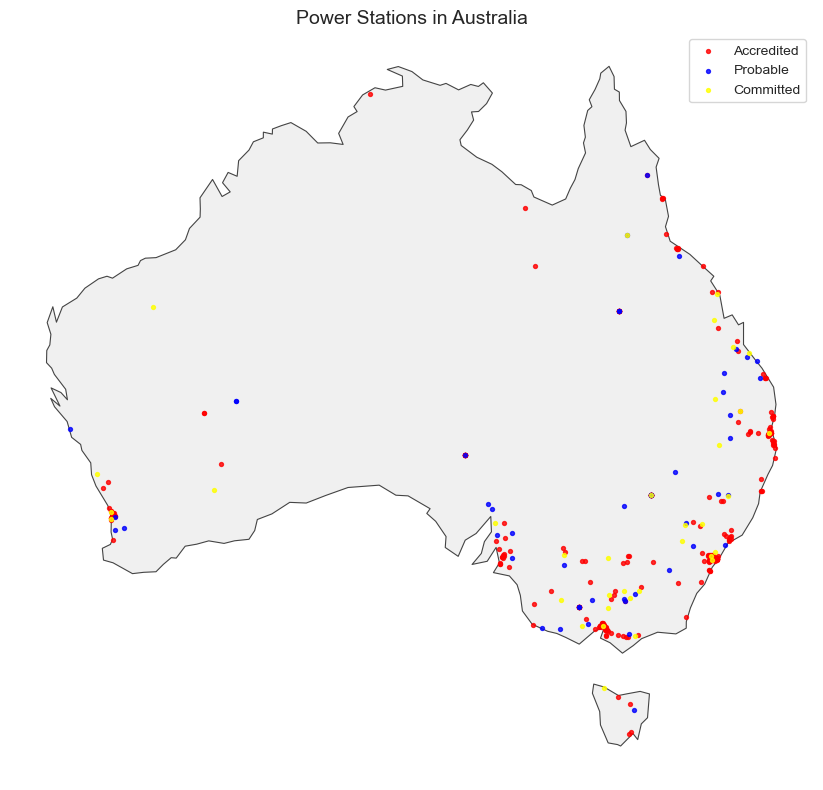

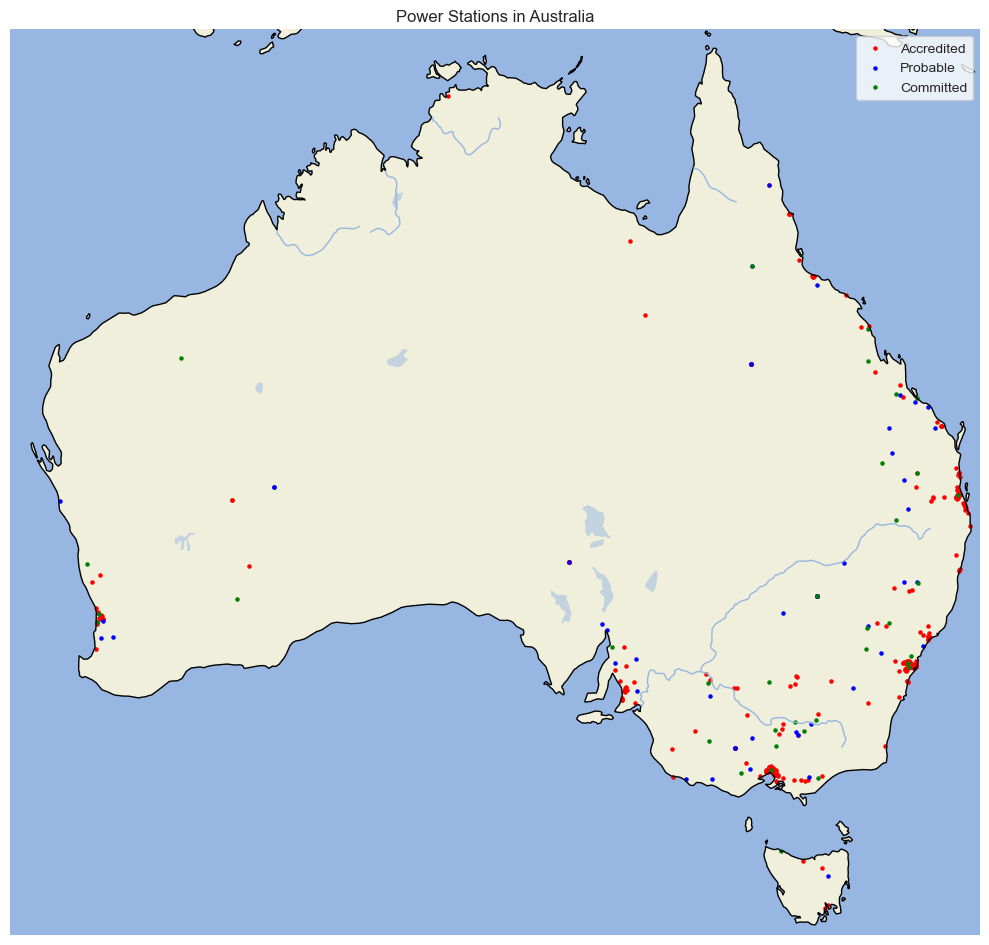

In [72]:
# Create a plot with a map projection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add Natural Earth features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Set the extent to Australia
ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())

# Plot the power stations
gdf1.plot(ax=ax, marker='o', color='red', markersize=5, transform=ccrs.Geodetic(),label='Accredited')
gdf2.plot(ax=ax, marker='o', color='blue', markersize=5, transform=ccrs.Geodetic(),label='Probable')
gdf3.plot(ax=ax, marker='o', color='green', markersize=5, transform=ccrs.Geodetic(),label='Committed')

# Set title
plt.title("Power Stations in Australia")

ax.set_axis_off()
ax.legend()   # 显示图例
plt.tight_layout()
plt.show()
